 # Opis notatnika
 Po pobraniu danych z zewnętrznego serwisu, a następnie załadowaniu ich do naszej wewnętrznej, firmowej bazy, czas na ich analizę oraz eksplorację.
 
 Eksplorację zaczynamy od centralnej bazy danych `flight`, w której nastawimy się w szczególności na zmienną `dep_delay` (za dokumentacją u [źródła](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations?resource=download&select=raw_data_documentation.txt)), która informuje o wysokości opóźnienia odlotu samolotu.
 
 Wykonując kolejne kroki, najpierw odpowiednio przygotujemy nasz wyjściowy zbiór do analizy, by później zacząć go wzbogacać o dodatkowe informacje, np. pogodowe.

 Dzięki wyciągnięciu wniosków z danych, które otrzymaliśmy, będziemy mogli zaproponować system raportowania wspomagający biznes czy zdefiniować dalsze kroki, które usprawnią działania lotnisk.

 # Konfiguracja
Tworzymy procedurę `load_table_from_db`, która będzie odpowiedzialna za pobieranie danych z bazy danych oraz zwrócenie ramki do dalszej pracy.

##### Importujemy potrzebne biblioteki oraz plik z ukrytymi danymi do logowania

In [431]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import plotly.express as px

In [3]:
# Ładujemy zmienne środowiskowe z pliku .env
load_dotenv('DB_pass.env')

True

##### Podłączamy się do bazy danych

In [6]:
# Tworzymy url połączenia
url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('N_DB_NAME')}"

# Tworzymy engine dla sqlalchemy
engine = create_engine(url)

##### Przygotowujemy implementację metody `read_sql_table`

In [9]:
def read_sql_table(table_name):
    print(f"Loading data from table {table_name} in chunks...")

    # Wczytujemy tabelę z bazy danych w fragmentach po 100 000 wierszy
    part_df = pd.read_sql_table(
        table_name=table_name,
        con=engine,
        schema=None, # jeśli używamy innego niż domyślny
        index_col=None, # kolumny, które mają być użyte jako indeksy
        coerce_float=True, # jeśli chcemy przekształcić kolumny float na float64
        parse_dates=None, # przekształcenie kolumn na datetime - można zmienić po lepszym zapoznaniu się z danymi
        columns=None, # wybór tylko niektórych kolumn do załadowania
        chunksize=100000 # ilość wierszy na raz - tutaj 100 000 powinno być optymalne
    )

    # Łączymy fragmenty w jeden DF
    df = pd.concat(part_df, ignore_index=True)

    print(f"Data loaded successfully from table {table_name}.")
    return df

 # Wczytanie danych do obszaru roboczego
 Używając metody `read_sql_table`, wczytujemy do obszaru roboczego zawartośc tabeli `flight` i zapisujemy w ramce o nazwie `flight_df_raw`.

 Po zapoznaniu się z kontekstem biznesowym nasze pierwsze zdania to:  
 1. Usunięcie z ramki lotów, które:
     * odbyły się w 2020 roku,
     * zostały anulowane.  
 2. Zmiana nazwy kolumny z `dep_delay_new` na `dep_delay`.  
 3. Tak powstałą tabelę zapisujemy do ramki, która nazywać się będzie `flight_df` - z tej ramki będziemy korzystali do końca analizy.  
 4. Wyznaczenie, ile kolumn ma tabela `flight_df`, wynik zapisujemy do zmiennej `flight_df_columns_amount`.  
 5. Wyznaczenie, ile wierszy ma tabela `flight_df`, wynik zapisujemy do zmiennej `flight_df_rows_amount`.

##### Wczytujemy ramkę do obszaru roboczego

In [13]:
flight_df_raw = read_sql_table('flight')
flight_df_raw.head() # Kolumna id pozostała nieusunięta, aby w trakcie dalszych prac móc łatwiej zlokalizować lub edytować poszczególne wiersze

Loading data from table flight in chunks...
Data loaded successfully from table flight.


,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,crs_elapsed_time,actual_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,210.0,205.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,210.0,220.0,1199.0,5,4.0,0.0,10.0,0.0,3.0,2019
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,120.0,124.0,581.0,3,NaN,NaN,NaN,NaN,NaN,2019


 ##### Oczyszczamy ramkę usuwając loty z roku 2020 oraz te anulowane

In [15]:
# Usuwamy wiersze, gdzie 'year' jest równe 2020
flight_df = flight_df_raw[flight_df_raw['year'] != 2020]

# Usuwamy wierszy, gdzie 'cancelled' jest równe 1
flight_df = flight_df[flight_df['cancelled'] != 1]

##### Zmieniamy nazwę kolumny `dep_delay_new` na `dep_delay`

In [17]:
flight_df.rename(columns={'dep_delay_new': 'dep_delay'}, inplace=True)

 Tutaj zainicjuj zmienne `flight_df_columns_amount` oraz `flight_df_rows_amount`, które zostaną użyte do sprawdzenia poprawności wykonania tej części

In [19]:
# Sprawdzamy wymiary ramkki danych
flight_df.shape

(1095742, 28)

In [20]:
# Liczba kolumn
flight_df_columns_amount = flight_df.shape[1]

# Liczba wierszy
flight_df_rows_amount = flight_df.shape[0]

 ## Sprawdzenie
 Uruchamiamy kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

 ### Sprawdzenie liczby kolumn

In [23]:
flight_df_expected_columns_amount = 28
assert flight_df_columns_amount == flight_df_expected_columns_amount, f'Oczekiwano {flight_df_expected_columns_amount} kolumn, otrzymano {flight_df_columns_amount}'

 ### Sprawdzenie liczby wierszy

In [25]:
flight_df_expected_rows_amount = 1095742
assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 ### Sprawdzenie czy nie zostały w ramce loty z 2020

In [27]:
flight_df_year_test = flight_df.loc[flight_df['year'] == 2020].shape[0]
assert flight_df_year_test == 0, 'W ramce `flight_df` nadal znajdują się loty z 2020 roku'

 ### Sprawdzenie czy nie zostały w ramce loty anulowane

In [29]:
flight_df_cancelled_test = flight_df.loc[flight_df['cancelled'] != 0].shape[0]
assert flight_df_cancelled_test == 0, 'W ramce `flight_df` nadal znajdują się anulowane loty'

 ### Sprawdzenie czy nazwa kolumny została poprawnie zmieniona

In [31]:
assert 'dep_delay' in flight_df.columns, 'Kolumna dep_delay nie została znaleziona w ramce flight_df'

 # Analiza kolumny `dep_delay`

 Wyznaczamy statystyki opisowe dla zmiennej `dep_delay` i zapisujemy do zmiennej `dep_delay_statistics_df`.
 W ramce powinny znaleźć się następujące wiersze:
 - średnia,
 - mediana,
 - odchylenie standardowe,
 - min, max
 - percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`

Wyniki zaokrąglamy do dwóch miejsc po przecinku.

In [34]:
# Obliczamy statystyki opisowe z dodatkowymi percentylami, od razu tworząc DF
dep_delay_statistics_df = flight_df['dep_delay'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2).to_frame().T
dep_delay_statistics_df

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
dep_delay,1095742.0,14.77,46.49,0.0,0.0,0.0,0.0,8.0,42.0,81.0,206.0,1959.0


Następnie dla kolumny `dep_delay`:  
 1. Wyznaczamy wykres dla _całej kolumny_ (tzn. tak jak jest).  
 2. Wyznaczamy wykres z pominięciem tych wierszy, dla których `dep_delay=0`.  
 3. Obcinając wykres do percentyla 95% oraz pomijając `dep_delay=0`.  

Dla wszystkich wykresów używamy histogramu z koszykami co 10 tj. `[0, 10)`, `[10, 20)` i tak dalej.

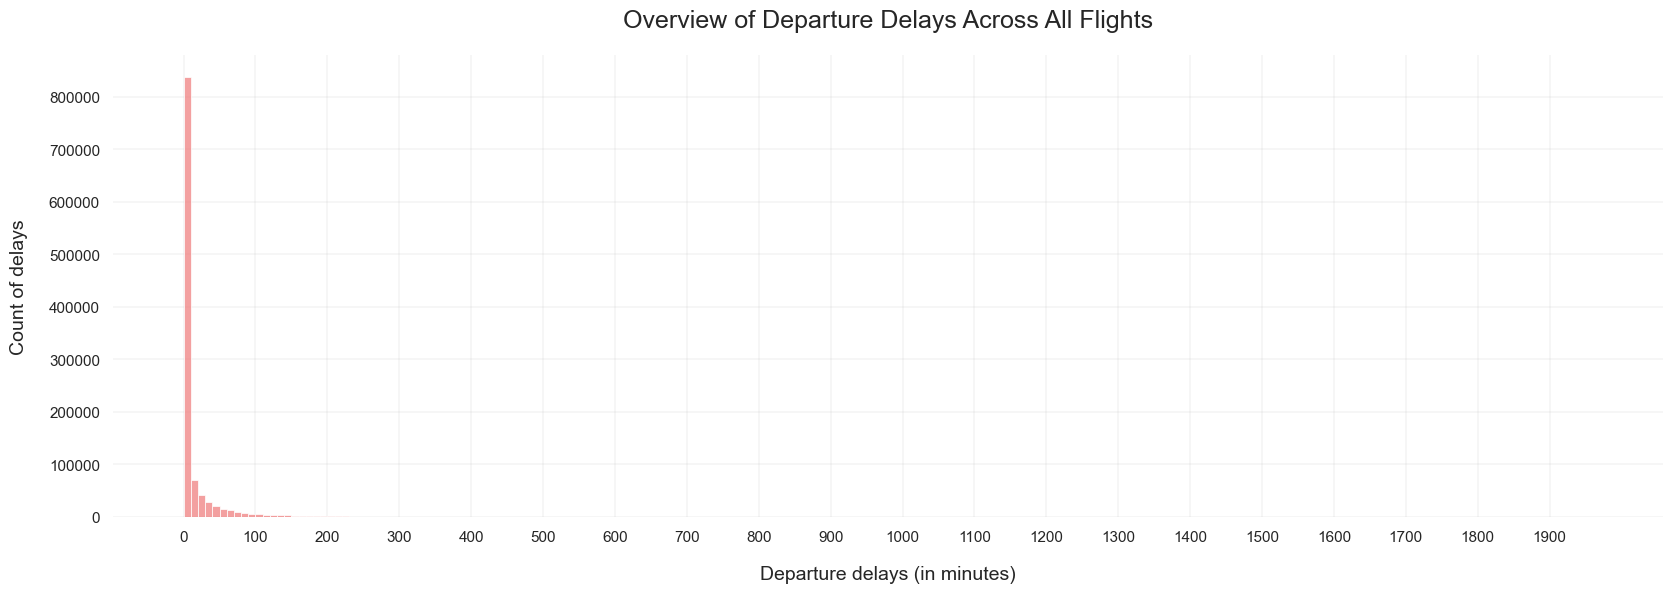

In [209]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy biny od 0 do maksymalnej wartości dep_delay, co 10 minut
bins = np.arange(0, flight_df['dep_delay'].max() + 10, 10)

# Tworzymy histogram z Seaborn
plt.figure(figsize=(20, 6))
sns.histplot(flight_df['dep_delay'], bins=bins, kde=False, color='lightcoral')

# Dodajemy tytuł i etykiety osi
plt.title('Overview of Departure Delays Across All Flights', fontsize=18, pad=20)
plt.xlabel('Departure delays (in minutes)', fontsize=14, labelpad=15)
plt.ylabel('Count of delays', fontsize=14, labelpad=15)

# Ustawiamy oś x z krokiem co 10 binów
plt.xticks(bins[::10])

# Wyświetlamy wykres
plt.show()


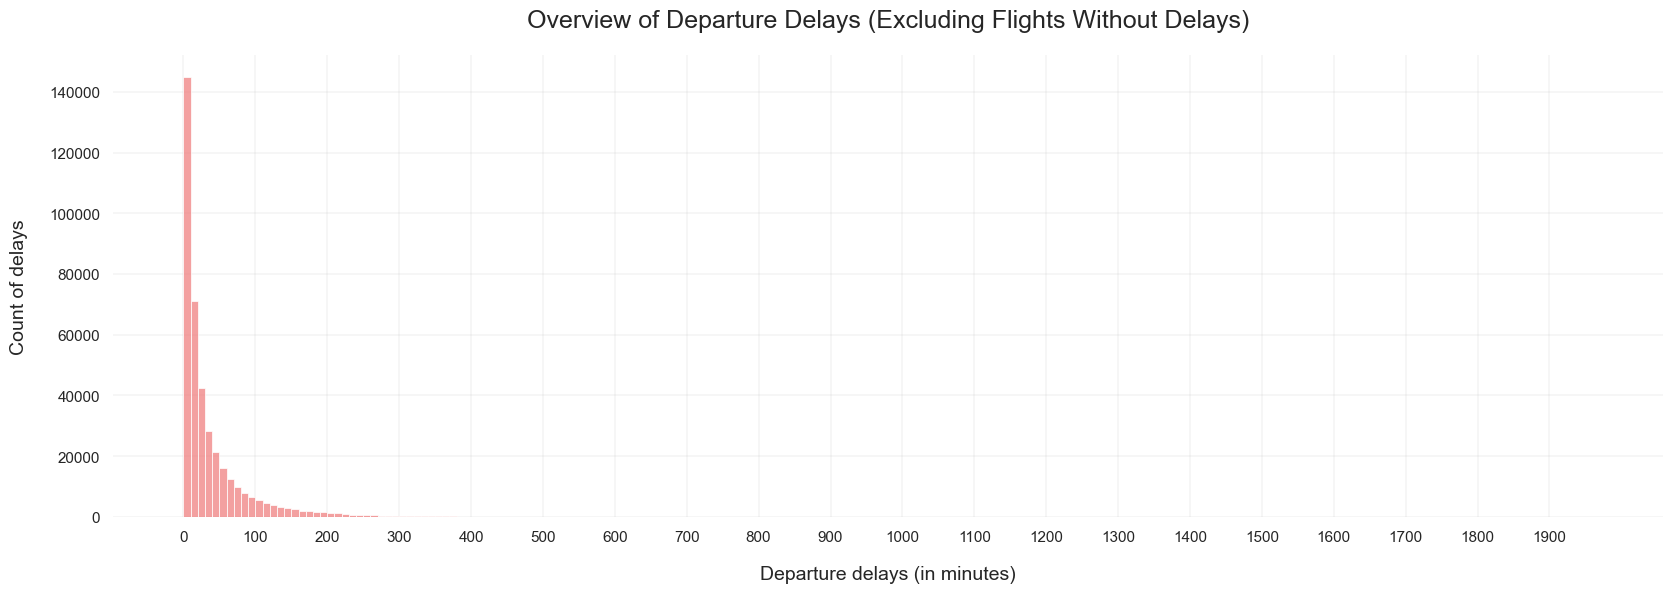

In [211]:
# Filtrujemy dane - pomijamy wiersze, gdzie dep_delay = 0
filtered_flight_df = flight_df[flight_df['dep_delay'] > 0]

# Tworzymy biny od 0 do maksymalnej wartości dep_delay w przefiltrowanych danych, co 10 minut
bins = np.arange(0, filtered_flight_df['dep_delay'].max() + 10, 10)

# Tworzymy histogram z Seaborn dla przefiltrowanych danych
plt.figure(figsize=(20, 6))
sns.histplot(filtered_flight_df['dep_delay'], bins=bins, kde=False, color='lightcoral')

# Dodajemy tytuł i etykiety osi
plt.title('Overview of Departure Delays (Excluding Flights Without Delays)', fontsize=18, pad=20)
plt.xlabel('Departure delays (in minutes)', fontsize=14, labelpad=15)
plt.ylabel('Count of delays', fontsize=14, labelpad=15)

# Ustawiamy oś x z krokiem co 10 binów
plt.xticks(bins[::10])

# Wyświetlamy wykres
plt.show()

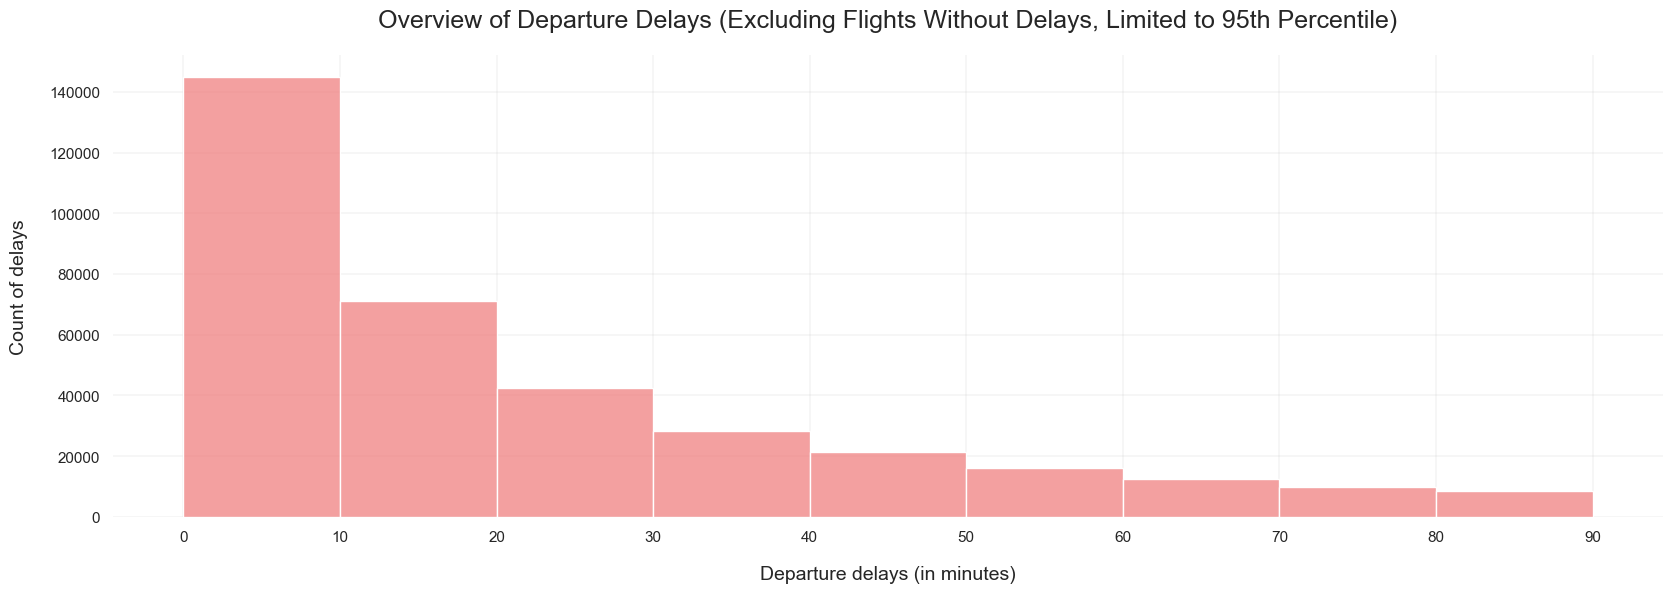

In [213]:
# Obliczamy wartość 95 percentyla dla dep_delay
percentile_95 = flight_df['dep_delay'].quantile(0.95)

# Filtrujemy dane - pomijamy wiersze, gdzie dep_delay = 0
filtered_flight_2_df = flight_df[flight_df['dep_delay'] > 0]

# Filtrujemy dane do wartości mniejszych lub równych 95 percentylowi
filtered_flight_2_df = filtered_flight_df[filtered_flight_2_df['dep_delay'] <= percentile_95]

# Tworzymy biny od 0 do 95 percentyla dep_delay, co 10 minut
bins = np.arange(0, percentile_95 + 10, 10)

# Tworzymy histogram z Seaborn dla przefiltrowanych danych
plt.figure(figsize=(20, 6))
sns.histplot(filtered_flight_df['dep_delay'], bins=bins, kde=False, color='lightcoral')

# Dodajemy tytuł i etykiety osi
plt.title('Overview of Departure Delays (Excluding Flights Without Delays, Limited to 95th Percentile)', fontsize=18, pad=20)
plt.xlabel('Departure delays (in minutes)', fontsize=14, labelpad=15)
plt.ylabel('Count of delays', fontsize=14, labelpad=15)

# Ustawiamy oś x
plt.xticks(bins)

# Wyświetlamy wykres
plt.show()

 # Analiza opóźnień
W ramce `flight_df` definiujemy nową kolumnę - `is_delayed` i loty, które posiadały opóźnienia, większe niż 15 minut, oznaczamy jako opóźnione.

Zgodnie z powyższą definicją, wyznaczami jaki procent wszystkich lotów był opóźniony. Wynik zapisujemy do zmiennej `delayed_ratio` z dokładnością do dwóch miejsc po przecinku.

In [215]:
# Dodajemy nową kolumnę is_delayed, uzupełnioną zgodnie z wymaganiami biznesowymi
flight_df['is_delayed'] = flight_df['dep_delay'].apply(lambda x: 1 if x > 15 else 0)

In [217]:
# Obliczamy procent opóźnionych lotów
delayed_ratio = float(round(flight_df['is_delayed'].mean(), 2))
delayed_ratio

0.19

 # Opóźnienia vs. miesiąc kalendarzowy
 Badamy, jak zmienia się odsetek opóźnień w zależności od **miesiąca kalendarzowego**. Zadanie wokonujemy w dwóch krokach:
 1. tworzymy zmienną `flight_delays_by_month_df` używając metody `groupby`,
 2. na podstawie zmiennej `flight_delays_by_month_df` generujemy odpowiedni wykres zgodnie z dobrymi praktykami.

In [219]:
# Grupujemy dane według miesiąca
flight_delays_by_month_df = flight_df.groupby('month').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

flight_delays_by_month_df

,total_flights,delayed_flights
month,,
1,86826,15697
2,79514,17379
3,91789,16160
4,89505,16361
5,94256,19293
6,92823,22985
7,95971,20796
8,98725,20764
9,90789,13406


In [221]:
# Obliczamy odsetek opóźnionych lotów w każdym miesiącu
flight_delays_by_month_df['delay_percentage'] = ((flight_delays_by_month_df['delayed_flights'] / flight_delays_by_month_df['total_flights']) * 100).round(2)
flight_delays_by_month_df

,total_flights,delayed_flights,delay_percentage
month,,,
1,86826,15697,18.08
2,79514,17379,21.86
3,91789,16160,17.61
4,89505,16361,18.28
5,94256,19293,20.47
6,92823,22985,24.76
7,95971,20796,21.67
8,98725,20764,21.03
9,90789,13406,14.77


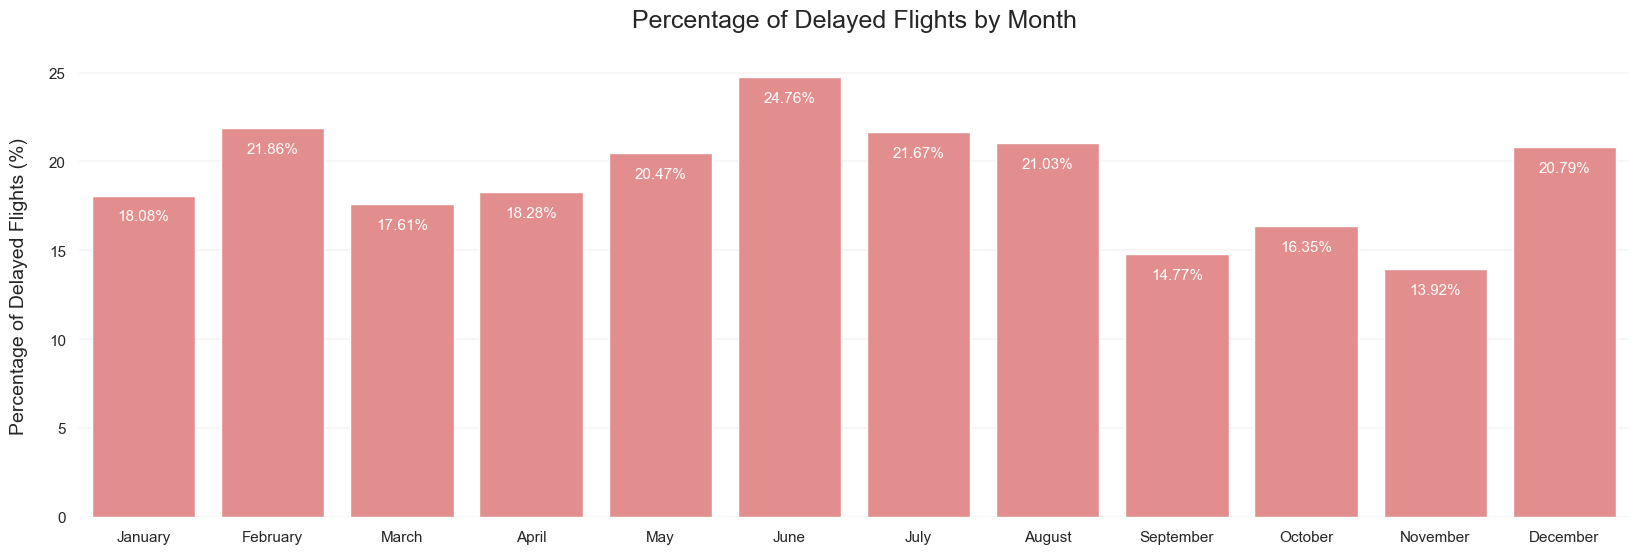

In [299]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy wykres słupkowy z Seaborn
plt.figure(figsize=(20, 6))
ax = sns.barplot(
    x=flight_delays_by_month_df.index, 
    y=flight_delays_by_month_df['delay_percentage'], 
    color='lightcoral'
)

# Dodajemy tytuł i etykiety osi
plt.title('Percentage of Delayed Flights by Month', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('Percentage of Delayed Flights (%)', fontsize=14, labelpad=15)

# Zmieniamy etykiety osi x na nazwy miesięcy
ax.set_xticks(range(12)) # ustawiamy 12 ticków, aby wyeliminować ostrzeżenie systemowe
ax.set_xticklabels(calendar.month_name[1:13])

# Dodajemy etykiety z wartościami procentowymi na słupkach
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, -15),
                textcoords='offset points',
                fontsize=11,
                color='white')

# Wyświetlamy wykres
plt.show()

 # Opóźnienia vs. dzień tygodnia cz. 1
 Badamy, jak zmienia się odsetek opóźnień w zależności od **dnia tygodnia**. Zadanie wykonujemy w dwóch krokach:
 1. tworzymy zmienną `flight_delays_by_weekday_df` używając metody `groupby`,
 2. na podstawie zmiennej `flight_delays_by_weekday_df`, generujemy odpowiedni wykres zgodnie z dobrymi praktykami.

In [259]:
# Grupujemy dane według miesiąca
flight_delays_by_weekday_df = flight_df.groupby('day_of_week').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

flight_delays_by_weekday_df

,total_flights,delayed_flights
day_of_week,,
1,164325,33073
2,162265,28356
3,160092,29262
4,162989,34581
5,165283,33590
6,127682,21429
7,153106,29459


In [261]:
# Obliczamy odsetek opóźnionych lotów w każdym dniu tygodnia
flight_delays_by_weekday_df['delay_percentage'] = ((flight_delays_by_weekday_df['delayed_flights'] / flight_delays_by_weekday_df['total_flights']) * 100).round(2)
flight_delays_by_weekday_df

,total_flights,delayed_flights,delay_percentage
day_of_week,,,
1,164325,33073,20.13
2,162265,28356,17.48
3,160092,29262,18.28
4,162989,34581,21.22
5,165283,33590,20.32
6,127682,21429,16.78
7,153106,29459,19.24


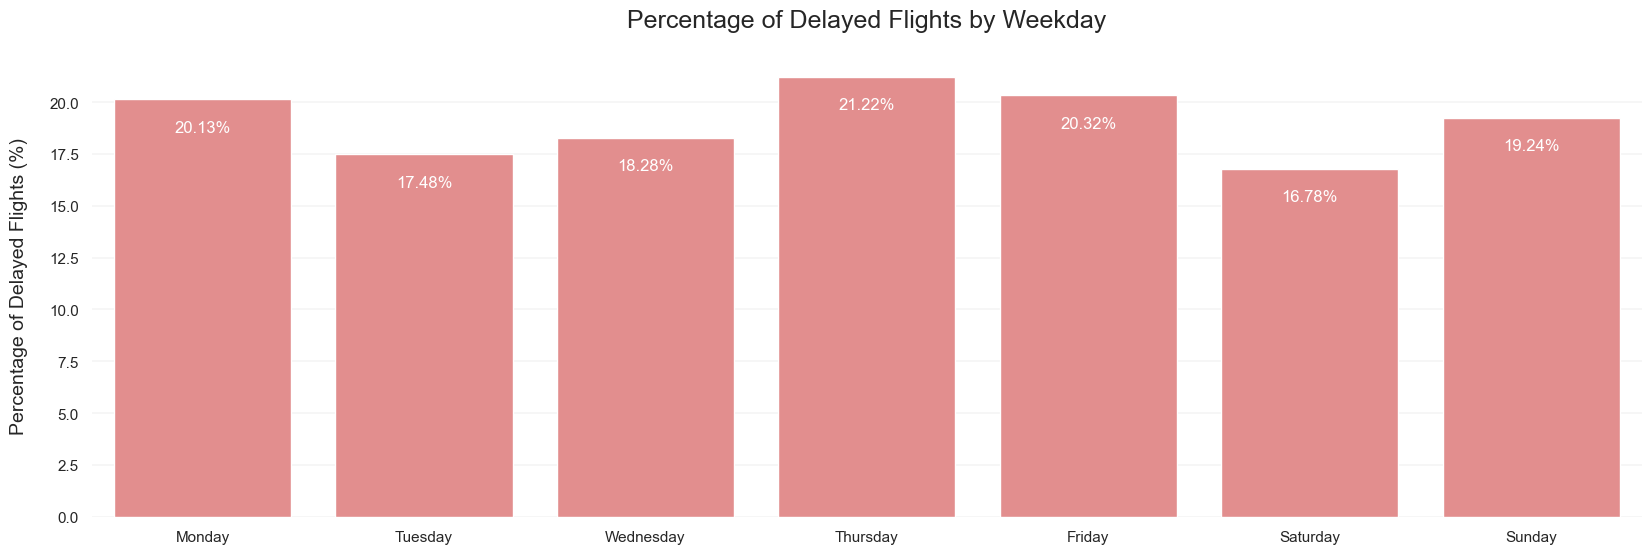

In [301]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy wykres słupkowy z Seaborn
plt.figure(figsize=(20, 6))
ax2 = sns.barplot(
    x=flight_delays_by_weekday_df.index, 
    y=flight_delays_by_weekday_df['delay_percentage'], 
    color='lightcoral'
)

# Dodajemy tytuł i etykiety osi
plt.title('Percentage of Delayed Flights by Weekday', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('Percentage of Delayed Flights (%)', fontsize=14, labelpad=15)

# Zmieniamy etykiety osi x na nazwy dni tygodnia
ax2.set_xticks(range(7)) # ustawiamy 7 ticków, aby wyeliminować ostrzeżenie systemowe
ax2.set_xticklabels(calendar.day_name[:7])

# Dodajemy etykiety z wartościami procentowymi na słupkach
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, -20),
                textcoords='offset points',
                fontsize=12,
                color='white')

# Wyświetlamy wykres
plt.show()

 # Opóźnienia vs. dzień tygodnia cz. 2
 Dokonujemy agregacji kolumny `day_of_week` do nowej kolumny `is_weekend` w `flight_df`, gdzie jako weekend przyjmujemy wartości 6 i 7.
 1. Używając grupowania, wyznaczamy odsetek opóźnień w zależności od tego, czy lot odbywał się w weekend czy nie. Wyniki zapisujemy do ramki `flight_delays_by_weekend_df` oraz zaokrąglamy do dwóch miejsc po przecinku.
 1. Prezentujemy graficznie wynik analizy.

In [313]:
# Dodajemy nową kolumnę is_weekend, uzupełnioną zgodnie z wymaganiami biznesowymi
flight_df['is_weekend'] = flight_df['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)

 Tutaj dokonaj agregacji danych do ramki `flight_delays_by_weekend_df`

In [316]:
# Grupujemy dane według miesiąca
flight_delays_by_weekend_df = flight_df.groupby('is_weekend').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

flight_delays_by_weekend_df

,total_flights,delayed_flights
is_weekend,,
0,814954,158862
1,280788,50888


In [362]:
# Obliczamy odsetek opóźnionych lotów w tygodniu roboczym i w weekend
flight_delays_by_weekend_df['delay_percentage'] = ((flight_delays_by_weekend_df['delayed_flights'] / flight_delays_by_weekend_df['total_flights']) * 100).round(2)
flight_delays_by_weekend_df

,total_flights,delayed_flights,delay_percentage
is_weekend,,,
0,814954,158862,19.49
1,280788,50888,18.12


 Tutaj narysuj wykres używając danych z ramki `flight_delays_by_weekend_df`

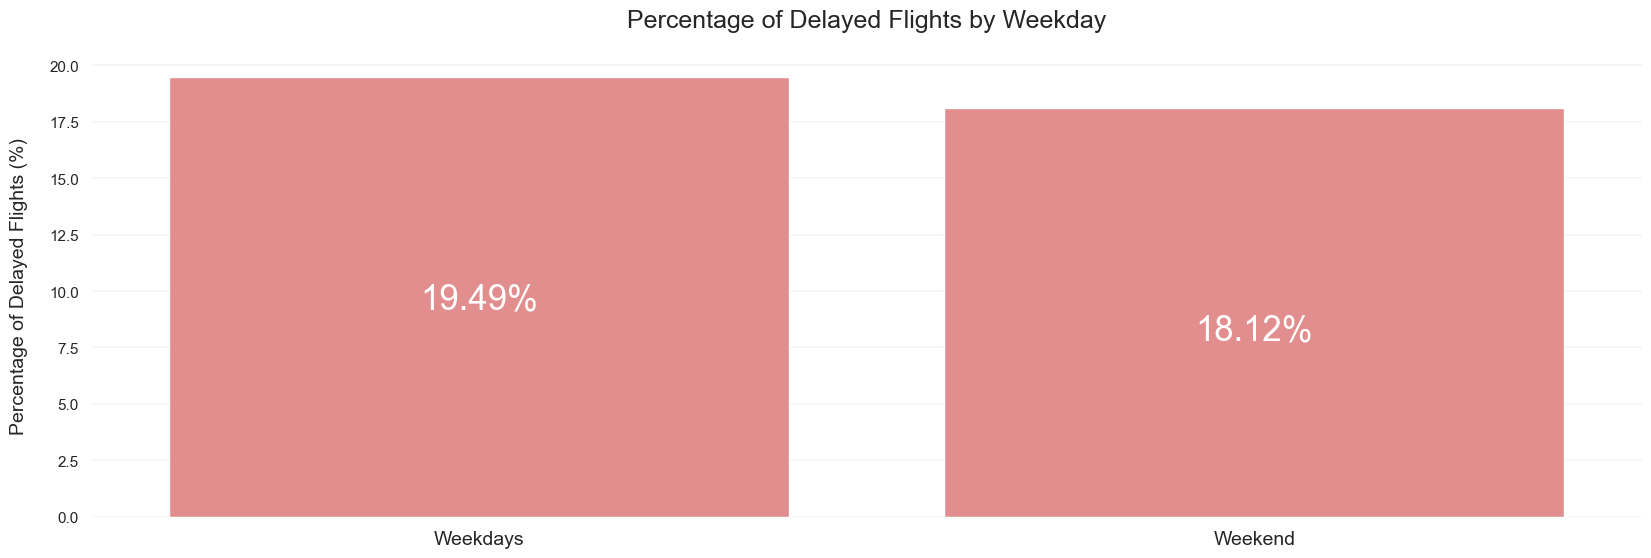

In [413]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy wykres słupkowy z Seaborn
plt.figure(figsize=(20, 6))
ax3 = sns.barplot(
    x=flight_delays_by_weekend_df.index, 
    y=flight_delays_by_weekend_df['delay_percentage'], 
    color='lightcoral'
)

# Dodajemy tytuł i etykiety osi
plt.title('Percentage of Delayed Flights by Weekday', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('Percentage of Delayed Flights (%)', fontsize=14, labelpad=15)

# Zmieniamy etykiety osi x na nazwy weekend / dni robocze
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Weekdays', 'Weekend'], fontsize=14)

# Dodajemy etykiety z wartościami procentowymi na słupkach
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, -160),
                textcoords='offset points',
                fontsize=25,
                color='white')

# Wyświetlamy wykres
plt.show()

##### Na podstawie samej różnicy procentowej nie można jednoznacznie stwierdzić, czy podział ten jest istotny. Aby uzyskać pełniejszy obraz, należy przeprowadzić testy statystyczne i rozważyć kontekst biznesowy. Dopiero po takiej analizie można podjąć decyzję, czy różnica w opóźnieniach między dniami roboczymi a weekendami wymaga dalszej uwagi.

##### Testy statystyczne mogą pomóc ustalić, czy różnica ta jest wystarczająco duża, aby uznać ją za istotną z punktu widzenia statystyki. Nawet jeśli różnica jest statystycznie istotna, trzeba rozważyć, czy ma ona znaczenie operacyjne - np. czy różnica wpływa na koszty, zasoby, zadowolenie klientów lub inne kluczowe wskaźniki efektywności.

##### Warto jednak zauważyć, że różnica na poziomie około 1,37 punktu procentowego jest stosunkowo mała.

 # Opóźnienia vs. odległość lotu
 Analizując kolumnę `distance`, aby zrealizować cel biznesowy, wykonujemy poniższe polecenia:  
 1. Podobnie jak dla zmiennej `dep_delay`, wyznaczamy statystyki opisowe oraz dodatkowo przedstawiamy percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`. Wynik zapisujemy do zmiennej `flight_distance_analysis_df` oraz zaokrąglamy do dwóch miejsc po przecinku.  
 2. Nakreślamy wykres punktowy (`scatter`) używając `distance` oraz `dep_delay`. Rysujemy wykres dla losowych 10 tysięcy wierszy. Czy na takim wykresie możesz coś zaobserwować?  
 3. Usuwamy z ramki `flight_df` te wiersze, dla których wartość `distance` jest powyżej 95% percentyla.  
 4. Używając ramki `flight_df`, dokonujemy agregacji zmiennej `distance` co 100 mil do nowej kolumny `distance_agg` oraz wyznaczamy odsetek opóźnień w każdym koszyku. Wynik zapisujemy do ramki o nazwie `flight_delays_by_distance_agg_df`.  
 5. Rysujemy wykres słupkowy, używając danych zapisanych w `flight_delays_by_distance_agg_df`.  
 6. Czy Twoim zdaniem większy dystans oznacza większe prawdopodobieństwo opóźnienia lotu? Uzasadnij.

In [426]:
# Obliczamy statystyki opisowe z dodatkowymi percentylami, od razu tworząc DF
flight_distance_analysis_df = flight_df['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2).to_frame().T
flight_distance_analysis_df

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
distance,1095742.0,758.08,600.43,100.0,216.0,337.0,606.0,937.0,1721.0,2475.0,2586.0,2586.0


##### Rysujemy wykres dla 10 000 losowych wierszy z tabeli `flight_df`

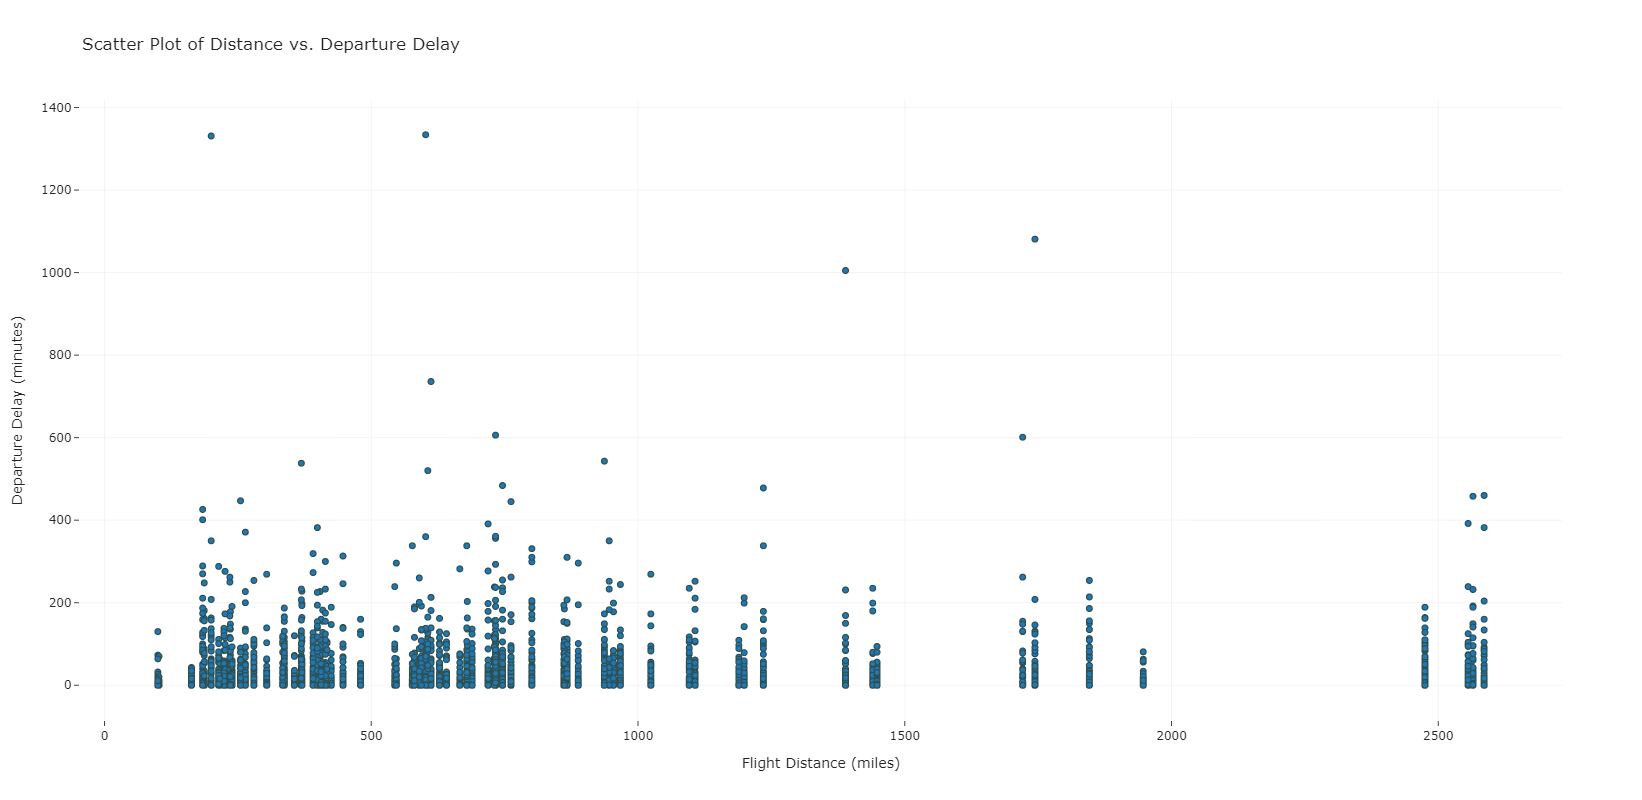

In [521]:
# Wczytujemy 10 000 losowych wierszy z tabeli flight_df i na tej podstawie wtorzymy wykres scatter plot za pomocą biblioteki Plotly
sample_df = flight_df.sample(n=10000, random_state=82)

fig = px.scatter(sample_df, x='distance', y='dep_delay',
                 title='Scatter Plot of Distance vs. Departure Delay',
                 labels={'distance': 'Flight Distance (miles)', 'dep_delay': 'Departure Delay (minutes)'},
                 template='simple_white')

# Dostosowujemy wygląd punktów (obwódki wokół punktów)
fig.update_traces(marker=dict(size=6,
                              line=dict(width=1, color='DarkSlateGrey')))

fig.update_layout(
    width=1200,
    height=800,
    xaxis=dict(showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False)
)

fig.show()

 #### ! Z ramki `flight_df` usuwamy wiersze, dla których wartość w kolmnie `distance` jest powyżej `95% percentyla` (> 95%) !

In [524]:
# Wyznaczamy wartość 95 percentyla dla kolumny distance
percentile_95_distance = flight_df['distance'].quantile(0.95)

# Usuwamy wiersze, dla których distance jest powyżej 95 percentyla w tej samej ramce i resetujemy indeks
flight_df = flight_df[flight_df['distance'] <= percentile_95_distance].reset_index(drop=True)

In [526]:
flight_df.shape

(1057391, 30)

##### Dokonujemy agregacji zmiennej `distance` oraz wyznaczamy odsetek opóźnień

In [530]:
# Agregujemy zmienną distance co 100 mil do nowej kolumny distance_agg, korzystając z dzielenia całkowitego
flight_df['distance_agg'] = (flight_df['distance'] // 100) * 100

In [538]:
# Wyznaczamy odsetek opóźnień w każdym koszyku
flight_delays_by_distance_agg_df = flight_df.groupby('distance_agg').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

In [540]:
flight_delays_by_distance_agg_df

,total_flights,delayed_flights
distance_agg,,
100.0,81316,10031
200.0,143794,27361
300.0,119149,23306
400.0,102970,17650
500.0,81201,13400
600.0,124170,24493
700.0,84422,19879
800.0,82012,17337
900.0,54411,12200


In [546]:
flight_delays_by_distance_agg_df['delay_percentage'] = ((flight_delays_by_distance_agg_df['delayed_flights'] /
                                                        flight_delays_by_distance_agg_df['total_flights']) * 100).round(2)

In [548]:
flight_delays_by_distance_agg_df

,total_flights,delayed_flights,delay_percentage
distance_agg,,,
100.0,81316,10031,12.34
200.0,143794,27361,19.03
300.0,119149,23306,19.56
400.0,102970,17650,17.14
500.0,81201,13400,16.50
600.0,124170,24493,19.73
700.0,84422,19879,23.55
800.0,82012,17337,21.14
900.0,54411,12200,22.42


##### Rysujemy wykres słupkowy używając danych zapisanych w `flight_delays_by_distance_agg_df`

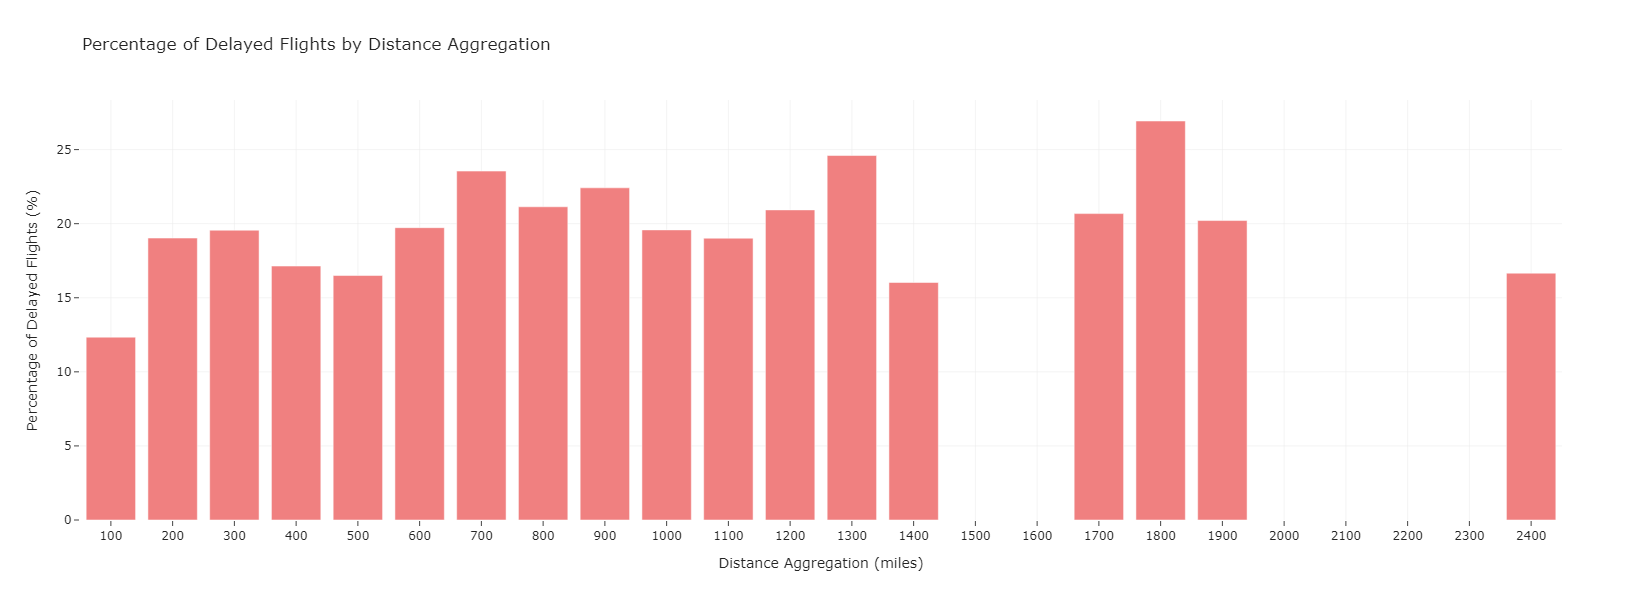

In [576]:
fig = px.bar(flight_delays_by_distance_agg_df.reset_index(), 
             x=flight_delays_by_distance_agg_df.index, 
             y='delay_percentage',
             title='Percentage of Delayed Flights by Distance Aggregation',
             labels={'index': 'Distance Aggregation (miles)', 'delay_percentage': 'Percentage of Delayed Flights (%)'},
             template='simple_white',
             color_discrete_sequence=['lightcoral'])

fig.update_layout(
    width=1200,
    height=600,
    xaxis_title='Distance Aggregation (miles)',
    xaxis=dict(tickmode='linear',dtick=100, showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False)
)

fig.show()

KOMENTARZ: Przy pracy z dużymi zbiorami danych wyświetlanie wszystkich punktów może prowadzić do problemów z czytelnością. Chociaż pokazujemy tylko wybrany fragment danych, zakładamy, że jest on wystarczająco reprezentatywny, aby odzwierciedlać ogólną charakterystykę całej populacji. W przypadku wykresu scatter plot dla losowo wybranych 10 000 lotów widać podobieństwo w kształcie wykresu. Na pierwszy rzut oka można zaobserwować można 3 wyróżniające się klastry, z czego pierwszy jest zdecydowanie najliczniejszy (100-1400 km, 1700-1900 km oraz 2400 km), zaś niezależnie od dystansu zdecydowana więkość opóźnień nie przekracza 80 minut. 

 # Opóźnienia vs. grupa odległości
 Analizujemy kolumnę `distance_group` dostępną w zbiorze danych oraz odpowiadamy na poniższe problemy biznesowe:  
 1. Dla jakich odcinków zostały wyznaczone poszczególne grupy? Wyznaczamy maksymalną oraz minimalną wartość `distance` w poszczególnych grupach. Wynik zapisujemy do ramki `flight_distance_by_distance_group`.  
 2. Wyznaczamy prawdopodobieństwo opóźnienia przy użyciu tych grup. Wynik zapisujemy do ramki `flight_delays_by_distance_group_df`.  
 3. Używając ramki `flight_delays_by_distance_group_df`, przygotowujemy odpowiedni wykres wizualizujący dane.  
 4. Na ile zbieżne są wyniki tej analizy z tą wykonaną w poprzednim punkcie?

##### Wyznaczamy odcinki, dla których zostały wyznaczone poszczególne grupy

In [597]:
flight_distance_by_distance_group = flight_df.groupby('distance_group').agg(
    min_distance=('distance', 'min'),
    max_distance=('distance', 'max')
)
flight_distance_by_distance_group

,min_distance,max_distance
distance_group,,
1,100.0,239.0
2,255.0,480.0
3,544.0,746.0
4,762.0,967.0
5,1024.0,1235.0
6,1389.0,1448.0
7,1721.0,1744.0
8,1846.0,1947.0
10,2475.0,2475.0


 ##### Wyznaczamy odsetek opóźnień w każdej grupie zapisując wyniki do ramki `flight_delays_by_distance_group_df`

In [599]:
flight_delays_by_distance_group_df = flight_df.groupby('distance_group').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

flight_delays_by_distance_group_df['delay_percentage'] = ((
    flight_delays_by_distance_group_df['delayed_flights'] / 
    flight_delays_by_distance_group_df['total_flights'] * 100
)).round(2)

flight_delays_by_distance_group_df

,total_flights,delayed_flights,delay_percentage
distance_group,,,
1,188524,29892,15.86
2,258705,48456,18.73
3,271023,53708,19.82
4,155193,33601,21.65
5,68753,13491,19.62
6,37542,7117,18.96
7,26906,5563,20.68
8,25212,5936,23.54
10,25533,4253,16.66


##### Rysujemy wykres przy użyciu ramki `flight_delays_by_distance_group_df`

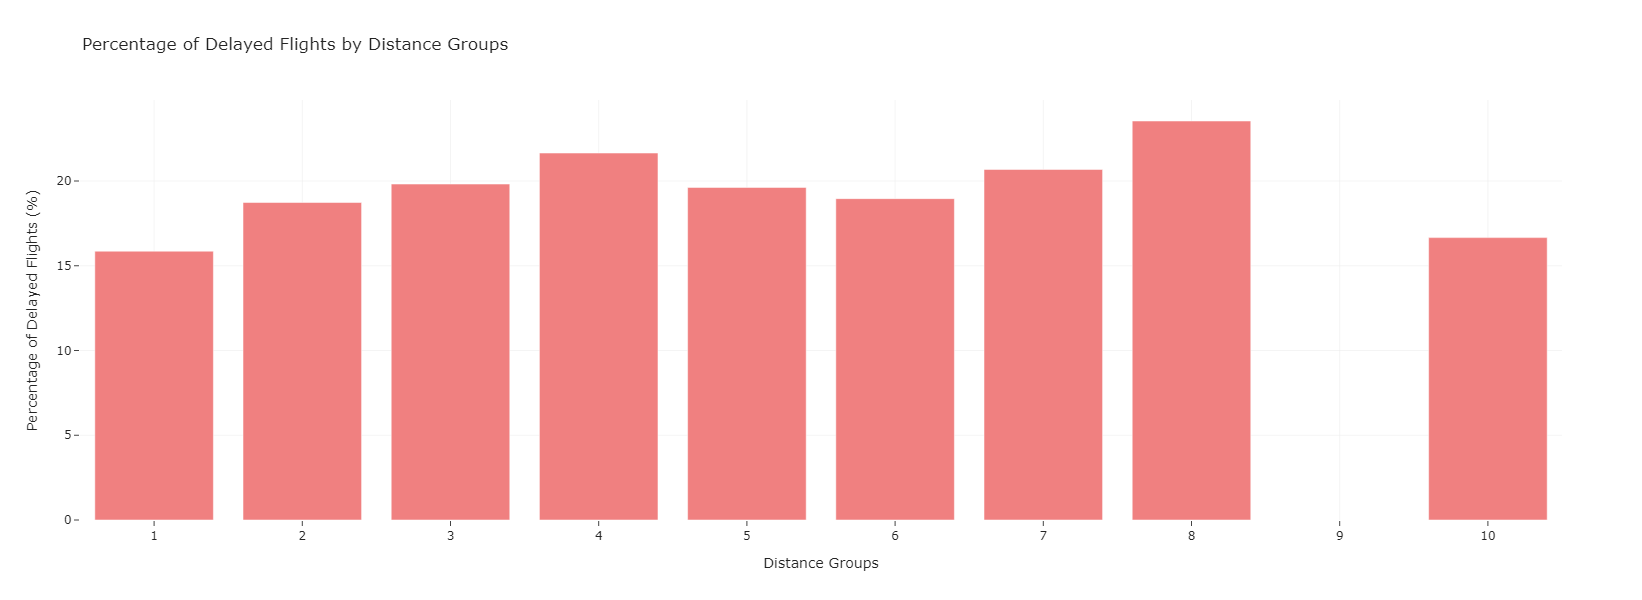

In [605]:
fig2 = px.bar(flight_delays_by_distance_group_df, 
             x=flight_delays_by_distance_group_df.index, 
             y='delay_percentage',
             title='Percentage of Delayed Flights by Distance Groups',
             labels={'index': 'Distance Groups', 'delay_percentage': 'Percentage of Delayed Flights (%)'},
             template='simple_white',
             color_discrete_sequence=['lightcoral'])

fig2.update_layout(
    width=1200,
    height=600,
    xaxis_title='Distance Groups',
    xaxis=dict(tickmode='linear',dtick=1, showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False)
)

fig2.show()

 ## Czy większy dystans oznacza większe prawdopodobieństwo opóźnenia lotu?

Na podstawie powyższych danych większy dystans wydaje się korelować z wyższym procentem opóźnień, jednakże nie jest to reguła bez wyjątków. Zaobserwowana zależność przypomina bardziej zależność wielomianową niż liniową, ponieważ nie widzimy stałego, proporcjonalnego wzrostu. Sugerować to może bardziej złożoną relację, dlatego warto przeprowadzić w tym kierunku regresję wielomianową. Pomimo, iż oba zestawy danych odnoszą się do odległości i opóźnień, distance_group grupuje dane w większe kategorie (np. 1-8), natomiast distance_agg agreguje je w mniejsze przedziały (np. 100, 200, 300 mil). Ze względu na większą ilość grup distance_agg pozwala na bardziej szczegółową analizę.

 # Podsumowanie
 W tym notatniku dość dokładnie przeanalizowaliśmy ramkę `fligh_delays` bez wzbogacania jej o dodatkowe dane z innych źródeł, takich jak dane pogodowe.

 Zanim przejdziemy dalej, należy zapisujemy lokalnie bieżącą postać ramki, która zostanie użyta w kolejnym notatniku.

In [624]:
# Ścieżka do zapisu pliku CSV
file_path = '../data/processed/flight_df_01.csv'

# Zapisujemy ramkę danych do pliku CSV
flight_df.to_csv(file_path, index=False)